In [6]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import math
import numpy as np
import os
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, leastsq
from scipy.stats import norm
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm

In [7]:
class GittinsIndex:
    def __init__(self, Sigma, n, N = 20, gamma = 0.9, xi = 3, delta = 0.02):
        self.Sigma = Sigma
        self.n = n
        self.mu = self.Sigma / self.n
        self.N = N
        self.gamma = gamma
        self.xi = xi
        self.delta = delta

    
    def valueFunction(self, Lambda = 0):
        mid = math.ceil(self.xi * np.sqrt(1 / self.n) / self.delta)
        number_mu = mid * 2 + 1
        mu_plus = np.linspace(self.mu - mid * delta, self.mu + mid * delta, num = number_mu) 
    
        v = [[0] * number_mu for _ in range(self.N + 1)]
        
        lo = mu_plus - delta / 2
        hi = mu_plus + delta / 2

        value_vec_prev = np.zeros(number_mu)
        value_vec_curr = np.zeros(number_mu)
        
        for i in range(number_mu):
            v[-1][i] = mu_plus[i] - Lambda
            value_vec_prev[i] = max(mu_plus[i] - Lambda, 0) / (1 - self.gamma) # without discount
            

        for t in tqdm(reversed(range(0, self.N))):  # from N - 1 to 0
            t_n = t + self.n
            s = np.sqrt(1 / t_n + 1)   
            y_hi, y_lo = hi * (t_n + 1), lo * (t_n + 1)
    
            for j in reversed(range(number_mu)):
                yhi = y_hi - mu_plus[j] * t_n
                ylo = y_lo - mu_plus[j] * t_n
                p = norm.cdf(yhi, loc = mu_plus[j], scale = s) - norm.cdf(ylo, loc = mu_plus[j], scale = s)

                risk_reward = mu_plus[j] + self.gamma * (norm.cdf(ylo[0], loc = mu_plus[j], scale = s) * value_vec_prev[0] +
                              (1 - norm.cdf(yhi[-1], loc = mu_plus[j], scale = s)) * value_vec_prev[-1] +
                              np.dot(p, value_vec_prev))

                v[t][j] = risk_reward - Lambda
                
                if risk_reward > Lambda: 
                    value_vec_curr[j] = risk_reward - Lambda  # discount factor already computed for every iter
                else:
                    value_vec_curr[j] = 0
                
            value_vec_prev = value_vec_curr.copy()
            
        return v

In [8]:
class MultiArmedBandits:
    def __init__(self, k = 10, epsilon = 0, initial = 0, true_expected_reward = 0, step_size = None, ucb = None, 
                 gradient = None, baseline = None, thompson = None, bayes_ucb = None, gittins = None, 
                 num_steps = 1000, num_runs = 2000):
        self.k = k
        self.epsilon = epsilon
        self.initial = initial
        self.initial_mu = true_expected_reward
        self.step_size = step_size
        self.ucb_c = ucb # degree of exploration
        self.gradient = gradient # step_size for gradient bandit algorithm
        self.baseline = baseline
        self.thompson = thompson
        self.bayes_ucb_c = bayes_ucb
        self.gi_values = gittins
        self.num_steps = num_steps
        self.num_runs = num_runs
        
        
    def new_bandit(self):
        self.q = np.zeros(self.k) + self.initial
        self.action_count = np.zeros(self.k).astype(int)
        self.mu = np.random.randn(self.k) + self.initial_mu
        self.action_optimal = np.argmax(self.mu)
        self.reward_episode = np.zeros(self.num_steps)
        self.action_episode = np.zeros(self.num_steps)
        if self.gradient:
            self.h = np.zeros(self.k)
            self.prev_rewards_bar = 0
            self.rewards_bar = 0
        if self.thompson or self.bayes_ucb_c:
            self.estimated_mu = np.zeros(self.k)
            self.estimated_var = np.zeros(self.k) + 1
            self.sample_var = self.s2
        
            
        
    # default: 1000 steps make up one episode/run    
    def episode(self):
        for step in range(self.num_steps):
            
            # choose action
            if np.random.random() < self.epsilon: # choose randomly
                action = np.random.randint(1,self.k)
            elif self.ucb_c:
                if min(self.action_count) == 0:
                    action = np.argmin(self.action_count)
                else:
                    ucb_action = self.q + self.ucb_c * np.sqrt(np.divide(np.log(step + 1), self.action_count))
                    action = np.argmax(ucb_action)
            elif self.gradient: # gradient bandit: only consider numerical preference
                h_exp = np.exp(self.h)
                pi = h_exp/np.sum(h_exp)
                action = np.random.choice(np.arange(self.k), p = pi)
            elif self.thompson:
                if min(self.action_count) == 0:
                    action = np.argmin(self.action_count)
                else:
                    action = np.argmax(np.random.normal(self.estimated_mu, np.sqrt(self.estimated_var)))
            elif self.bayes_ucb_c:
                if min(self.action_count) == 0:
                    action = np.argmin(self.action_count)
                else:
                    quantile = norm.ppf(1 - 1 / ((step + 1) * pow(np.log(self.num_steps), self.bayes_ucb_c)), self.estimated_mu, np.sqrt(self.estimated_var))
                    action = np.random.choice(np.where(quantile == max(quantile))[0])
            elif self.gi_values[0]:
                if min(self.action_count) == 0:
                    action = np.argmin(self.action_count)
                else:
                    action = np.argmax(self.q + self.gi_values[self.action_count - 1])
            else:
                action = np.argmax(self.q)  
            
            
            # update action
            self.action_count[action] += 1
            if action == self.action_optimal:
                self.action_episode[step] = 1

                
            # receive rewards
            reward = self.s2 * np.random.randn() + self.mu[action]  # s2: sd within a single arm
            self.reward_episode[step] = reward
            
            
            # update parameters
            if self.step_size:
                self.q[action] += self.step_size * (reward - self.q[action])  # constant step-size
            elif self.gradient:
                h_action = np.zeros(self.k)
                h_action[action] = 1
                if self.baseline: # if no baseline, q is constantly 0
                    self.rewards_bar += (reward - self.rewards_bar) / (step + 1) # average of all rewards
                self.h += self.gradient * (reward - self.rewards_bar) * (h_action - pi) # update h, eq. 2.12 stochastic gradient ascent              
            elif self.thompson or self.bayes_ucb_c:
                if self.action_count[action] == 1:  # likelihood of first obs. as prior
                    self.estimated_mu[action] = reward
                else:
                    self.estimated_mu[action] += (reward - self.estimated_mu[action]) / self.action_count[action]
                    self.estimated_var[action] = 1 / self.action_count[action]
            else: 
                self.q[action] += (reward - self.q[action]) / self.action_count[action]  # sample average
        return self.reward_episode, self.action_episode
    
    # default: average of 2000 runs
    def simulate(self):
        average_reward = np.zeros((self.num_runs, self.num_steps))
        action_percentage = np.zeros((self.num_runs, self.num_steps))
        for run in tqdm(range(self.num_runs)):
            self.new_bandit()
            average_reward[run], action_percentage[run] = self.episode()
        return [np.mean(average_reward, axis = 0), np.mean(action_percentage, axis = 0), np.mean(average_reward, axis = 1)]

## horizon = n = 32, \gamma = 0.96875 = 1-1/n

In [10]:
N = 64
xi = 6
n = 1
delta = 0.001
v = GittinsIndex(Sigma = 0, n = 1, N = N, gamma = 0.96875, xi = xi, delta = delta).valueFunction(Lambda = 0)

In [61]:
a = int(xi / delta / 2)
roots = np.zeros(N)
for j in range(N):
    roots[j] = -fsolve(interp1d(np.linspace(-xi, xi, num = int(xi / delta) * 2 + 1)[a : -a], v[j][a : -a]), 0)

/Users/yuxin/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [62]:
roots

array([1.16612919, 0.75192372, 0.57166225, 0.46681977, 0.3970619 ,
       0.34681821, 0.30867134, 0.27859548, 0.2541998 , 0.23396789,
       0.21688799, 0.20225535, 0.18956399, 0.17844054, 0.16860313,
       0.15983418, 0.15196437, 0.14485914, 0.13840766, 0.13251959,
       0.12712194, 0.12215589, 0.11756865, 0.11331507, 0.10935954,
       0.10566941, 0.10221687, 0.09897842, 0.09593549, 0.09306763,
       0.09035938, 0.08779269, 0.08535786, 0.0830406 , 0.0808361 ,
       0.07873008, 0.07671368, 0.0747791 , 0.07291958, 0.07113078,
       0.06940382, 0.06772906, 0.06610383, 0.06452427, 0.06297788,
       0.06146848, 0.05997868, 0.05851378, 0.05705514, 0.05560665,
       0.05414967, 0.05268242, 0.05118822, 0.04965751, 0.04806958,
       0.04641186, 0.04464605, 0.04273899, 0.04063833, 0.03826134,
       0.0354812 , 0.03206413, 0.02754775, 0.02060215])

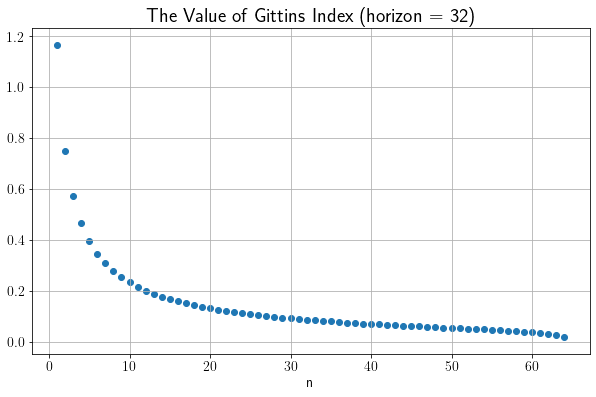

In [63]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.scatter(list(range(1, N + 1)), roots)
plt.xlabel("n")
plt.title(r"The Value of Gittins Index (horizon = 32)", fontsize = 20)
plt.grid()
plt.show()

In [64]:
gi_32 = roots

In [5]:
gittins_steps32_runs1000000 = MultiArmedBandits(gittins = gi_32, num_steps = 32, num_runs = 1000000).simulate()

In [8]:
thompson_steps32_runs1000000 = MultiArmedBandits(thompson = True, num_steps = 32, num_runs = 1000000).simulate()

In [9]:
print("Gittins Index mean: " + str(np.mean(gittins_steps32_runs1000000[2])))
print("Gittins Index std: " + str(np.std(gittins_steps32_runs1000000[2])/np.sqrt(1000000)))
print("Thompson Sampling mean: " + str(np.mean(thompson_steps32_runs1000000[2])))
print("Thompson Sampling std: " + str(np.std(thompson_steps32_runs1000000[2])/np.sqrt(1000000)))


Gittins Index mean: 0.842957903846971
Gittins Index std: 0.0005426417055993562
Thompson Sampling mean: 0.7100550149768273
Thompson Sampling std: 0.0005251377270993534


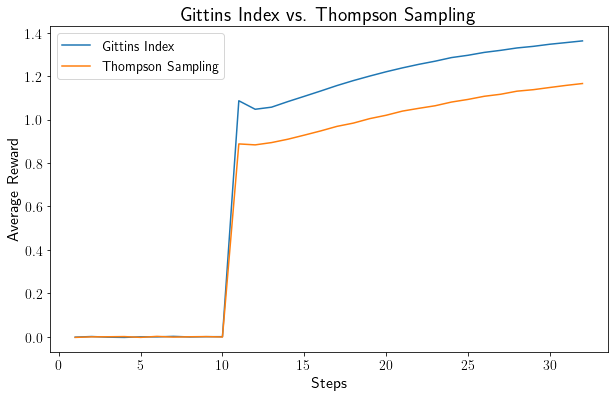

In [10]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 32 + 1)), gittins_steps32_runs1000000[0], label="Gittins Index")
plt.plot(list(range(1, 32 + 1)), thompson_steps32_runs1000000[0], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

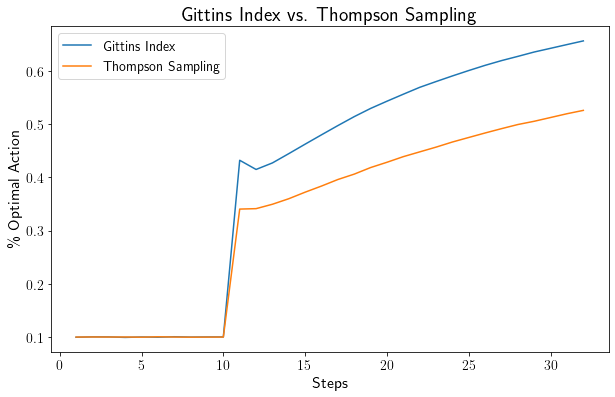

In [11]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 32 + 1)), gittins_steps32_runs1000000[1], label="Gittins Index")
plt.plot(list(range(1, 32 + 1)), thompson_steps32_runs1000000[1], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal Action", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

## horizon = n = 64, \gamma = 0.984375 = 1-1/n

In [70]:
N = 128
xi = 6
n = 1
delta = 0.001
v = GittinsIndex(Sigma = 0, n = 1, N = N, gamma = 0.984375, xi = xi, delta = delta).valueFunction(Lambda = 0)

In [71]:
a = int(xi / delta / 2)
roots = np.zeros(N)
for j in range(N):
    roots[j] = -fsolve(interp1d(np.linspace(-xi, xi, num = int(xi / delta) * 2 + 1)[a : -a], v[j][a : -a]), 0)

In [72]:
roots

array([1.41665051, 0.92800111, 0.7136386 , 0.58805262, 0.50395303,
       0.44303018, 0.396536  , 0.35970591, 0.32970372, 0.30472389,
       0.28355798, 0.26536316, 0.24953325, 0.23561899, 0.22328063,
       0.21225602, 0.202339  , 0.19336456, 0.18519988, 0.17773753,
       0.17088669, 0.1645749 , 0.15873585, 0.15331873, 0.14827715,
       0.14357255, 0.1391695 , 0.13504122, 0.13116363, 0.12751092,
       0.12406149, 0.12080439, 0.11771904, 0.11479136, 0.11201046,
       0.10936949, 0.10684985, 0.10444914, 0.10215317, 0.09995967,
       0.09786288, 0.09585247, 0.09392383, 0.09207425, 0.09029894,
       0.08858837, 0.08693978, 0.08535728, 0.0838272 , 0.08235312,
       0.08092679, 0.07955405, 0.07822111, 0.07693258, 0.07568987,
       0.07448231, 0.07330952, 0.07217098, 0.07106608, 0.06999446,
       0.06895525, 0.06794389, 0.06695937, 0.06600155, 0.06507165,
       0.06416557, 0.06328157, 0.06241793, 0.0615731 , 0.060746  ,
       0.05993793, 0.0591544 , 0.0583876 , 0.0576325 , 0.05689

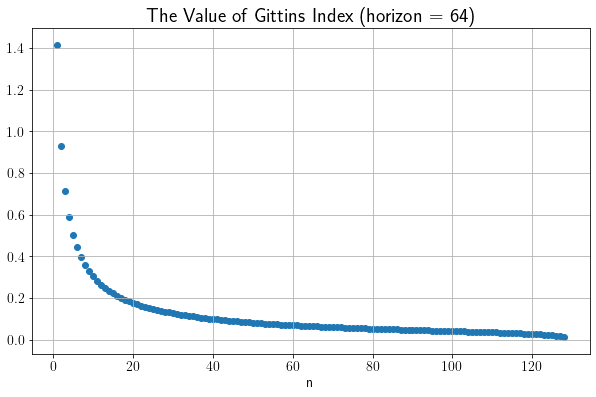

In [73]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.scatter(list(range(1, N + 1)), roots)
plt.xlabel("n")
plt.title(r"The Value of Gittins Index (horizon = 64)", fontsize = 20)
plt.grid()
plt.show()

In [74]:
gi_64 = roots

In [12]:
gittins_steps64_runs1000000 = MultiArmedBandits(gittins = gi_64, num_steps = 64, num_runs = 1000000).simulate()
thompson_steps64_runs1000000 = MultiArmedBandits(thompson = True, num_steps = 64, num_runs = 1000000).simulate()
print("Gittins Index mean: " + str(np.mean(gittins_steps64_runs1000000[2])))
print("Gittins Index std: " + str(np.std(gittins_steps64_runs1000000[2])/np.sqrt(1000000)))
print("Thompson Sampling mean: " + str(np.mean(thompson_steps64_runs1000000[2])))
print("Thompson Sampling std: " + str(np.std(thompson_steps64_runs1000000[2])/np.sqrt(1000000)))



Gittins Index mean: 1.1177549927377357
Gittins Index std: 0.0005857321308153461
Thompson Sampling mean: 0.9903412565750304
Thompson Sampling std: 0.0005775460673863642


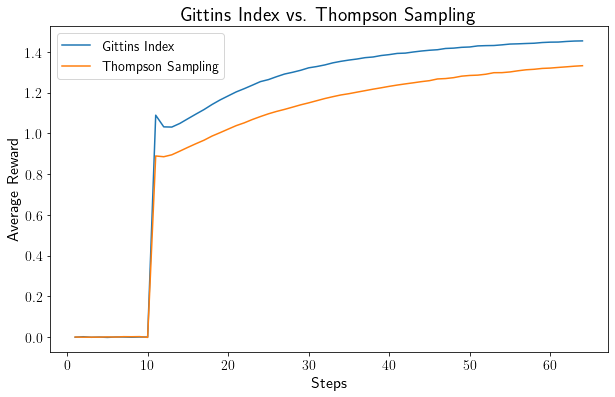

In [13]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 64 + 1)), gittins_steps64_runs1000000[0], label="Gittins Index")
plt.plot(list(range(1, 64 + 1)), thompson_steps64_runs1000000[0], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

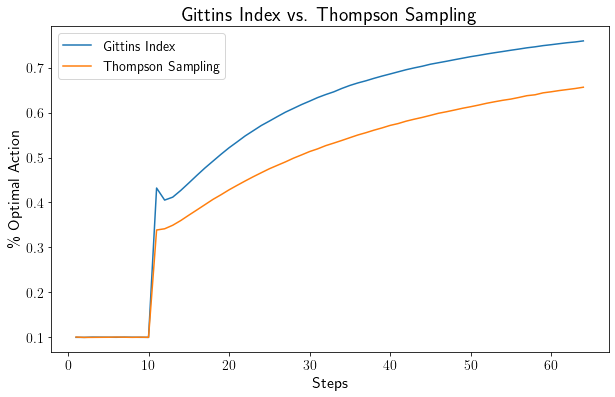

In [14]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 64 + 1)), gittins_steps64_runs1000000[1], label="Gittins Index")
plt.plot(list(range(1, 64 + 1)), thompson_steps64_runs1000000[1], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal Action", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

## horizon = n = 128, \gamma = 0.9921875 = 1-1/n

In [32]:
N = 256
xi = 6
n = 1
delta = 0.001
v = GittinsIndex(Sigma = 0, n = 1, N = N, gamma = 0.9921875, xi = xi, delta = delta).valueFunction(Lambda = 0)

In [33]:
a = int(xi / delta / 2)
roots = np.zeros(N)
for j in range(N):
    roots[j] = -fsolve(interp1d(np.linspace(-xi, xi, num = int(xi / delta) * 2 + 1)[a : -a], v[j][a : -a]), 0)

In [34]:
roots

array([1.66276307, 1.10387176, 0.85724639, 0.7119489 , 0.61415613,
       0.54298823, 0.48844833, 0.44507838, 0.40962384, 0.38000508,
       0.35483202, 0.33312907, 0.31419544, 0.29751017, 0.28267747,
       0.26939302, 0.25741598, 0.24655448, 0.23665314, 0.22758518,
       0.21924487, 0.21154587, 0.20441233, 0.19778213, 0.1916032 ,
       0.18582693, 0.18041681, 0.17533463, 0.17055144, 0.16603897,
       0.16177995, 0.15774692, 0.15392267, 0.15029476, 0.14684268,
       0.14355821, 0.14042481, 0.13743366, 0.13457446, 0.13183773,
       0.12921916, 0.12670828, 0.12429718, 0.12197966, 0.11975804,
       0.11761773, 0.11555561, 0.11356781, 0.11164993, 0.10979763,
       0.10800919, 0.10628752, 0.10461713, 0.10299775, 0.10143882,
       0.09992051, 0.09845502, 0.09702684, 0.09565026, 0.09430691,
       0.09300044, 0.09174081, 0.09051133, 0.08931244, 0.08814462,
       0.08700929, 0.08590929, 0.08483685, 0.08379075, 0.08277023,
       0.08177438, 0.08080226, 0.07985295, 0.07892607, 0.07802

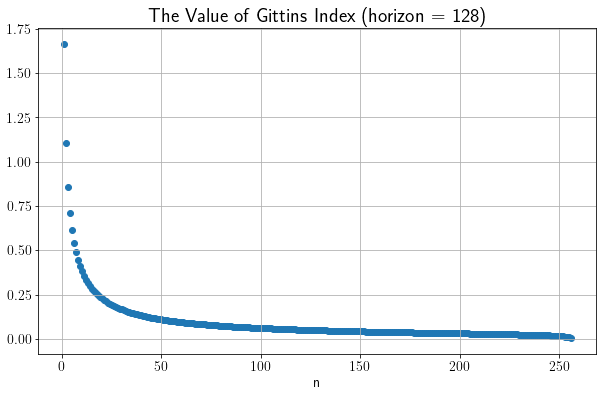

In [59]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.scatter(list(range(1, N + 1)), roots)
plt.xlabel("n")
plt.title(r"The Value of Gittins Index (horizon = 128)", fontsize = 20)
plt.grid()
plt.show()

In [36]:
gi_128 = roots

In [15]:
gittins_steps128_runs1000000 = MultiArmedBandits(gittins = gi_128, num_steps = 128, num_runs = 1000000).simulate()
thompson_steps128_runs1000000 = MultiArmedBandits(thompson = True, num_steps = 128, num_runs = 1000000).simulate()
print("Gittins Index mean: " + str(np.mean(gittins_steps128_runs1000000[2])))
print("Gittins Index std: " + str(np.std(gittins_steps128_runs1000000[2])/np.sqrt(1000000)))
print("Thompson Sampling mean: " + str(np.mean(thompson_steps128_runs1000000[2])))
print("Thompson Sampling std: " + str(np.std(thompson_steps128_runs1000000[2])/np.sqrt(1000000)))



Gittins Index mean: 1.2886506563881828
Gittins Index std: 0.0005990498358527098
Thompson Sampling mean: 1.1910158146187324
Thompson Sampling std: 0.0005997427850081204


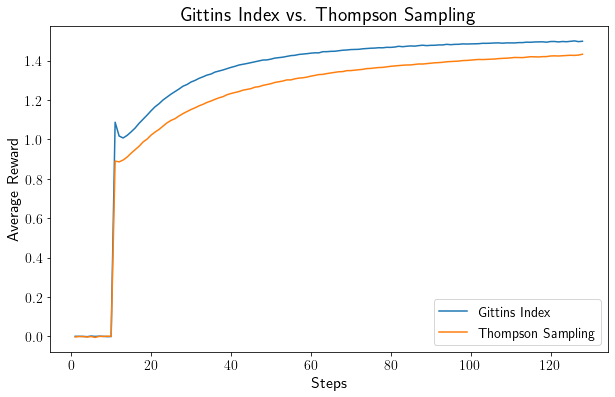

In [16]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 128 + 1)), gittins_steps128_runs1000000[0], label="Gittins Index")
plt.plot(list(range(1, 128 + 1)), thompson_steps128_runs1000000[0], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

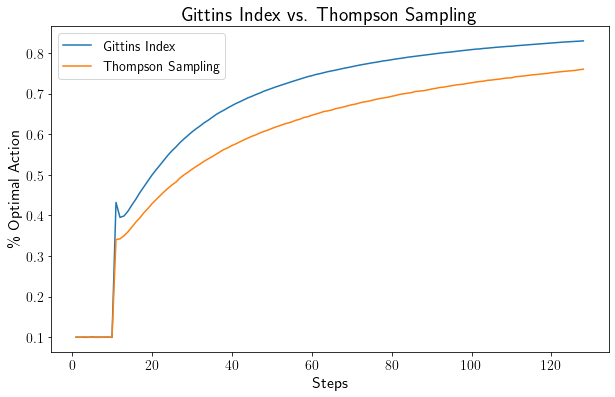

In [17]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 128 + 1)), gittins_steps128_runs1000000[1], label="Gittins Index")
plt.plot(list(range(1, 128 + 1)), thompson_steps128_runs1000000[1], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal Action", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

## horizon = n = 256, \gamma = 0.99609375 = 1-1/n

In [40]:
N = 512
xi = 6
n = 1
delta = 0.001
v = GittinsIndex(Sigma = 0, n = 1, N = N, gamma = 0.99609375, xi = xi, delta = delta).valueFunction(Lambda = 0)

In [41]:
a = int(xi / delta / 2)
roots = np.zeros(N)
for j in range(N):
    roots[j] = -fsolve(interp1d(np.linspace(-xi, xi, num = int(xi / delta) * 2 + 1)[a : -a], v[j][a : -a]), 0)

In [43]:
roots

array([1.90183336, 1.27674813, 0.9997415 , 0.83585457, 0.7251196 ,
       0.64424592, 0.58206277, 0.53246693, 0.49180565, 0.45774916,
       0.42873015, 0.40365309, 0.38172589, 0.3623612 , 0.34511155,
       0.32963363, 0.31565162, 0.30294834, 0.29135094, 0.28070966,
       0.27090642, 0.26184367, 0.2534353 , 0.24560775, 0.23830107,
       0.2314627 , 0.22504445, 0.21901221, 0.21332983, 0.20796001,
       0.20288396, 0.19807342, 0.1935099 , 0.18916752, 0.18503501,
       0.18109908, 0.17734315, 0.17375112, 0.17031497, 0.16702153,
       0.16386928, 0.16084237, 0.15793392, 0.1551407 , 0.15245297,
       0.14986034, 0.14736531, 0.14495445, 0.14263479, 0.14038931,
       0.13821733, 0.13611723, 0.13408651, 0.13212181, 0.13021913,
       0.12837401, 0.12658204, 0.12484083, 0.12315403, 0.12151687,
       0.11991996, 0.118375  , 0.11686576, 0.11540189, 0.11397029,
       0.11258658, 0.11122975, 0.10990877, 0.10862694, 0.10737065,
       0.10614227, 0.10494693, 0.1037857 , 0.10264898, 0.10153

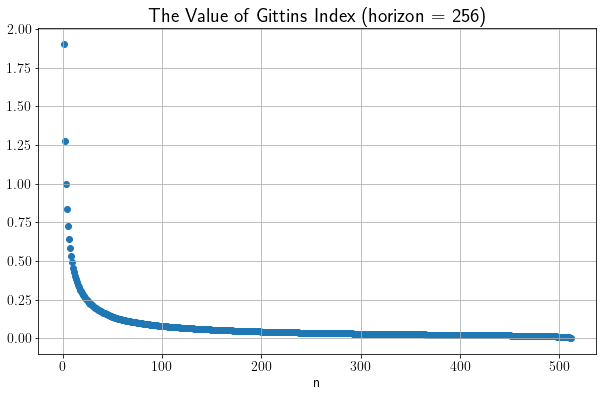

In [48]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.scatter(list(range(1, N + 1)), roots)
plt.xlabel("n")
plt.title(r"The Value of Gittins Index (horizon = 256)", fontsize = 20)
plt.grid()
plt.show()

In [44]:
gi_256 = roots

In [18]:
gittins_steps256_runs1000000 = MultiArmedBandits(gittins = gi_256, num_steps = 256, num_runs = 1000000).simulate()
thompson_steps256_runs1000000 = MultiArmedBandits(thompson = True, num_steps = 256, num_runs = 1000000).simulate()
print("Gittins Index mean: " + str(np.mean(gittins_steps256_runs1000000[2])))
print("Gittins Index std: " + str(np.std(gittins_steps256_runs1000000[2])/np.sqrt(1000000)))
print("Thompson Sampling mean: " + str(np.mean(thompson_steps256_runs1000000[2])))
print("Thompson Sampling std: " + str(np.std(thompson_steps256_runs1000000[2])/np.sqrt(1000000)))



Gittins Index mean: 1.3903600644089507
Gittins Index std: 0.0006011623340134961
Thompson Sampling mean: 1.3266172211195755
Thompson Sampling std: 0.0006065861119220683


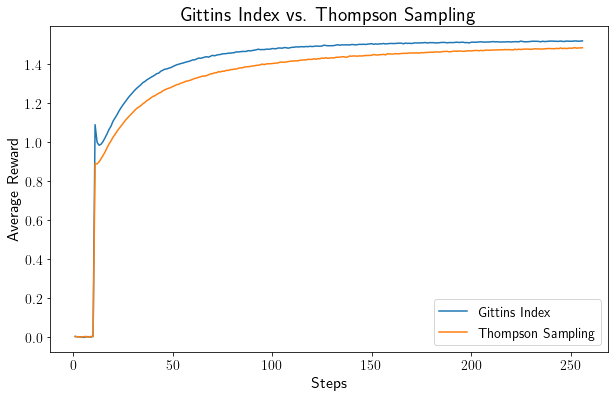

In [19]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 256 + 1)), gittins_steps256_runs1000000[0], label="Gittins Index")
plt.plot(list(range(1, 256 + 1)), thompson_steps256_runs1000000[0], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

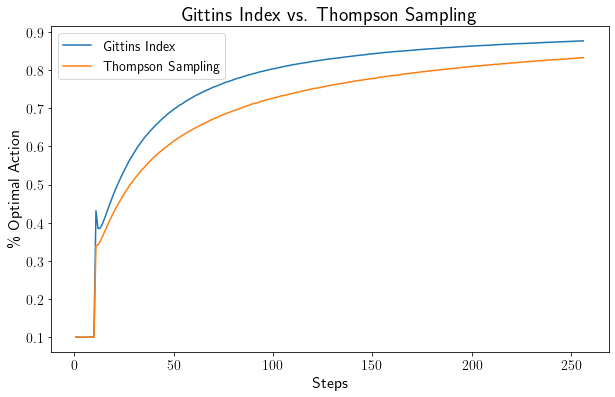

In [20]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 256 + 1)), gittins_steps256_runs1000000[1], label="Gittins Index")
plt.plot(list(range(1, 256 + 1)), thompson_steps256_runs1000000[1], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal Action", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

## horizon = n = 512, \gamma = 0.998046875 = 1-1/n

In [78]:
N = 1024
xi = 6
n = 1
delta = 0.001
v = GittinsIndex(Sigma = 0, n = 1, N = N, gamma = 0.998046875, xi = xi, delta = delta).valueFunction(Lambda = 0)

In [79]:
a = int(xi / delta / 2)
roots = np.zeros(N)
for j in range(N):
    roots[j] = -fsolve(interp1d(np.linspace(-xi, xi, num = int(xi / delta) * 2 + 1)[a : -a], v[j][a : -a]), 0)

In [80]:
roots

array([2.13223755, 1.44468304, 1.13908879, ..., 0.00379599, 0.00303841,
       0.00220511])

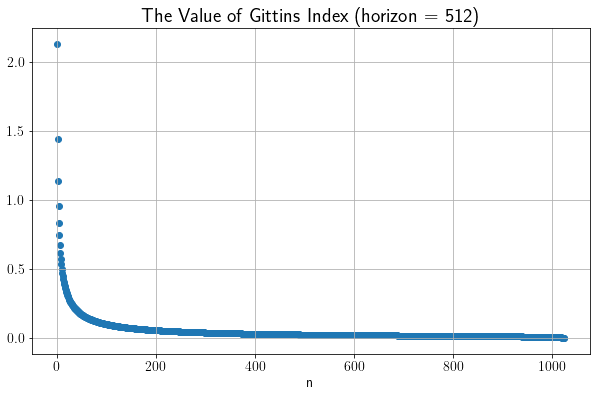

In [81]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.scatter(list(range(1, N + 1)), roots)
plt.xlabel("n")
plt.title(r"The Value of Gittins Index (horizon = 512)", fontsize = 20)
plt.grid()
plt.show()

In [82]:
gi_512 = roots

In [21]:
gittins_steps512_runs1000000 = MultiArmedBandits(gittins = gi_512, num_steps = 512, num_runs = 1000000).simulate()
thompson_steps512_runs1000000 = MultiArmedBandits(thompson = True, num_steps = 512, num_runs = 1000000).simulate()
print("Gittins Index mean: " + str(np.mean(gittins_steps512_runs1000000[2])))
print("Gittins Index std: " + str(np.std(gittins_steps512_runs1000000[2])/np.sqrt(1000000)))
print("Thompson Sampling mean: " + str(np.mean(thompson_steps512_runs1000000[2])))
print("Thompson Sampling std: " + str(np.std(thompson_steps512_runs1000000[2])/np.sqrt(1000000)))



Gittins Index mean: 1.4524867391553657
Gittins Index std: 0.0005990150841560096
Thompson Sampling mean: 1.4130152336382928
Thompson Sampling std: 0.0006038313474044609


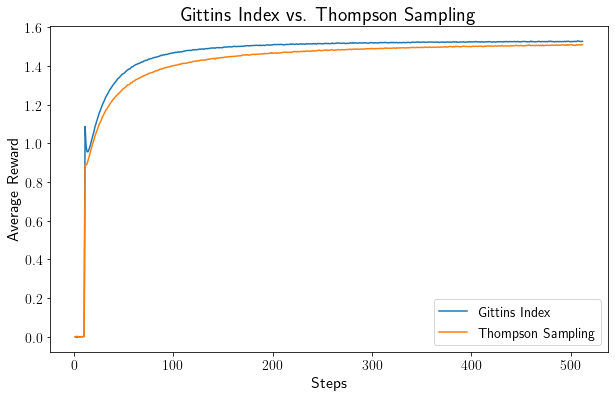

In [22]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 512 + 1)), gittins_steps512_runs1000000[0], label="Gittins Index")
plt.plot(list(range(1, 512 + 1)), thompson_steps512_runs1000000[0], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

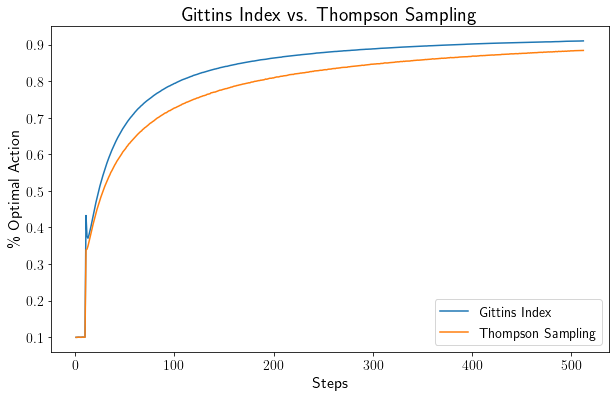

In [23]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 512 + 1)), gittins_steps512_runs1000000[1], label="Gittins Index")
plt.plot(list(range(1, 512 + 1)), thompson_steps512_runs1000000[1], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal Action", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

## plot of Gittins index for different horizons that determines fixed gamma

In [11]:
%store -r gi_32
%store -r gi_64
%store -r gi_128
%store -r gi_256
%store -r gi_512

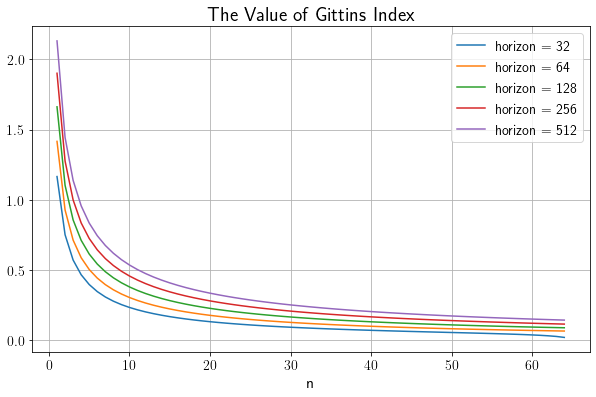

In [13]:
fig = plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 64 + 1)), gi_32, label = "horizon = 32")
plt.plot(list(range(1, 64 + 1)), gi_64[:64], label = "horizon = 64")
plt.plot(list(range(1, 64 + 1)), gi_128[:64], label = "horizon = 128")
plt.plot(list(range(1, 64 + 1)), gi_256[:64], label = "horizon = 256")
plt.plot(list(range(1, 64 + 1)), gi_512[:64], label = "horizon = 512")
plt.xlabel("n", fontsize = 16)
plt.title(r"The Value of Gittins Index", fontsize = 20)
plt.legend()
plt.grid()
plt.show()
fig.savefig('/Users/yuxin/Desktop/gi_values.pdf', bbox_inches='tight')

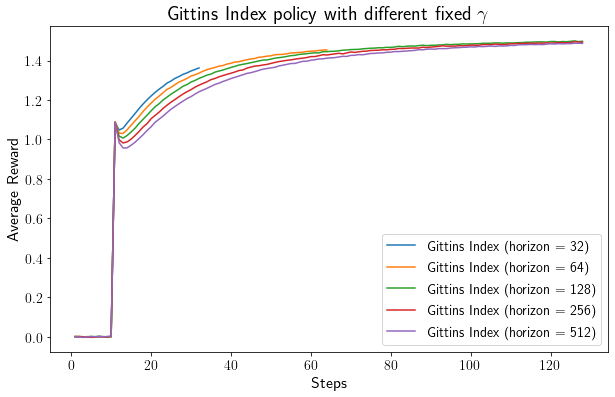

In [28]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 32 + 1)), gittins_steps32_runs1000000[0], label = "Gittins Index (horizon = 32)")
plt.plot(list(range(1, 64 + 1)), gittins_steps64_runs1000000[0], label = "Gittins Index (horizon = 64)")
plt.plot(list(range(1, 128 + 1)), gittins_steps128_runs1000000[0], label = "Gittins Index (horizon = 128)")
plt.plot(list(range(1, 128 + 1)), gittins_steps256_runs1000000[0][:128], label = "Gittins Index (horizon = 256)")
plt.plot(list(range(1, 128 + 1)), gittins_steps512_runs1000000[0][:128], label = "Gittins Index (horizon = 512)")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title(r"Gittins Index policy with different fixed $\gamma$", fontsize = 20)
plt.legend()

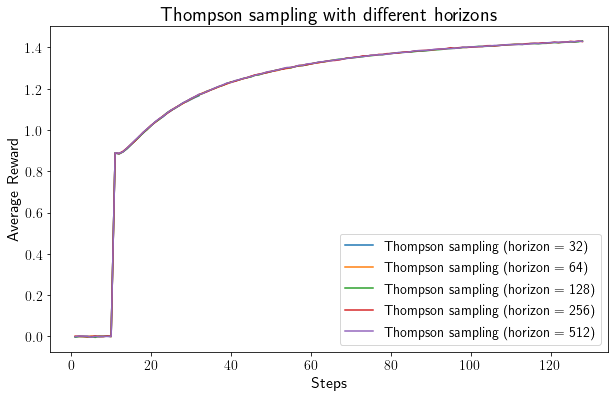

In [29]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 32 + 1)), thompson_steps32_runs1000000[0], label = "Thompson sampling (horizon = 32)")
plt.plot(list(range(1, 64 + 1)), thompson_steps64_runs1000000[0], label = "Thompson sampling (horizon = 64)")
plt.plot(list(range(1, 128 + 1)), thompson_steps128_runs1000000[0], label = "Thompson sampling (horizon = 128)")
plt.plot(list(range(1, 128 + 1)), thompson_steps256_runs1000000[0][:128], label = "Thompson sampling (horizon = 256)")
plt.plot(list(range(1, 128 + 1)), thompson_steps512_runs1000000[0][:128], label = "Thompson sampling (horizon = 512)")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title(r"Thompson sampling with different horizons", fontsize = 20)
plt.legend()

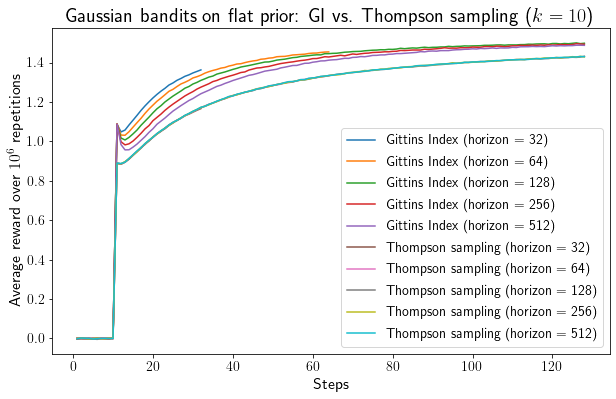

In [26]:
fig = plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 32 + 1)), gittins_steps32_runs1000000[0], label = "Gittins Index (horizon = 32)")
plt.plot(list(range(1, 64 + 1)), gittins_steps64_runs1000000[0], label = "Gittins Index (horizon = 64)")
plt.plot(list(range(1, 128 + 1)), gittins_steps128_runs1000000[0], label = "Gittins Index (horizon = 128)")
plt.plot(list(range(1, 128 + 1)), gittins_steps256_runs1000000[0][:128], label = "Gittins Index (horizon = 256)")
plt.plot(list(range(1, 128 + 1)), gittins_steps512_runs1000000[0][:128], label = "Gittins Index (horizon = 512)")

plt.plot(list(range(1, 32 + 1)), thompson_steps32_runs1000000[0], label = "Thompson sampling (horizon = 32)")
plt.plot(list(range(1, 64 + 1)), thompson_steps64_runs1000000[0], label = "Thompson sampling (horizon = 64)")
plt.plot(list(range(1, 128 + 1)), thompson_steps128_runs1000000[0], label = "Thompson sampling (horizon = 128)")
plt.plot(list(range(1, 128 + 1)), thompson_steps256_runs1000000[0][:128], label = "Thompson sampling (horizon = 256)")
plt.plot(list(range(1, 128 + 1)), thompson_steps512_runs1000000[0][:128], label = "Thompson sampling (horizon = 512)")

plt.xlabel("Steps", fontsize = 16)
plt.ylabel(r"Average reward over $10^6$ repetitions", fontsize = 16)
plt.title(r"Gaussian bandits on flat prior: GI vs. Thompson sampling ($k = 10$)", fontsize = 20)
plt.legend()

## compare with UCB
* c = 1

In [ ]:
ucb1_steps32_runs1000000 = MultiArmedBandits(ucb = 1, num_steps = 32, num_runs = 1000000).simulate()
ucb1_steps64_runs1000000 = MultiArmedBandits(ucb = 1, num_steps = 64, num_runs = 1000000).simulate()
ucb1_steps128_runs1000000 = MultiArmedBandits(ucb = 1, num_steps = 128, num_runs = 1000000).simulate()
ucb1_steps256_runs1000000 = MultiArmedBandits(ucb = 1, num_steps = 256, num_runs = 1000000).simulate()
ucb1_steps512_runs1000000 = MultiArmedBandits(ucb = 1, num_steps = 512, num_runs = 1000000).simulate()

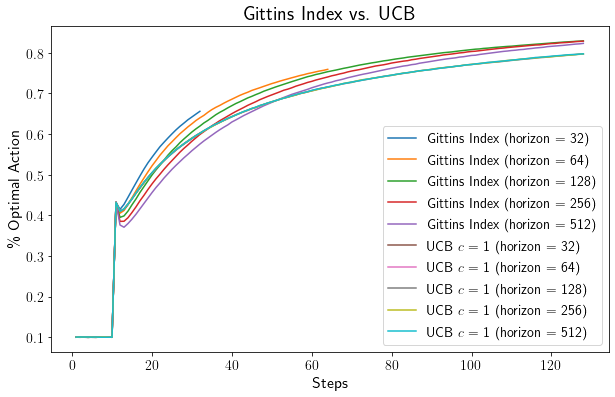

In [43]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 32 + 1)), gittins_steps32_runs1000000[1], label = "Gittins Index (horizon = 32)")
plt.plot(list(range(1, 64 + 1)), gittins_steps64_runs1000000[1], label = "Gittins Index (horizon = 64)")
plt.plot(list(range(1, 128 + 1)), gittins_steps128_runs1000000[1], label = "Gittins Index (horizon = 128)")
plt.plot(list(range(1, 128 + 1)), gittins_steps256_runs1000000[1][:128], label = "Gittins Index (horizon = 256)")
plt.plot(list(range(1, 128 + 1)), gittins_steps512_runs1000000[1][:128], label = "Gittins Index (horizon = 512)")

plt.plot(list(range(1, 32 + 1)), ucb1_steps32_runs1000000[1], label = r"UCB $c$ = 1 (horizon = 32)")
plt.plot(list(range(1, 64 + 1)), ucb1_steps64_runs1000000[1], label = "UCB $c$ = 1 (horizon = 64)")
plt.plot(list(range(1, 128 + 1)), ucb1_steps128_runs1000000[1], label = "UCB $c$ = 1 (horizon = 128)")
plt.plot(list(range(1, 128 + 1)), ucb1_steps256_runs1000000[1][:128], label = "UCB $c$ = 1 (horizon = 256)")
plt.plot(list(range(1, 128 + 1)), ucb1_steps512_runs1000000[1][:128], label = "UCB $c$ = 1 (horizon = 512)")

plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal Action", fontsize = 16)
plt.title("Gittins Index vs. UCB", fontsize = 20)
plt.legend()

In [44]:
print("UCB c = 1, horizon = 32, mean: " + str(np.mean(ucb1_steps32_runs1000000[2])))
print("UCB c = 1, horizon = 32, std: " + str(np.std(ucb1_steps32_runs1000000[2])/np.sqrt(1000000)))

print("UCB c = 1, horizon = 64, mean: " + str(np.mean(ucb1_steps64_runs1000000[2])))
print("UCB c = 1, horizon = 64, std: " + str(np.std(ucb1_steps64_runs1000000[2])/np.sqrt(1000000)))

print("UCB c = 1, horizon = 128, mean: " + str(np.mean(ucb1_steps128_runs1000000[2])))
print("UCB c = 1, horizon = 128, std: " + str(np.std(ucb1_steps128_runs1000000[2])/np.sqrt(1000000)))

print("UCB c = 1, horizon = 256, mean: " + str(np.mean(ucb1_steps256_runs1000000[2])))
print("UCB c = 1, horizon = 256, std: " + str(np.std(ucb1_steps256_runs1000000[2])/np.sqrt(1000000)))

print("UCB c = 1, horizon = 512, mean: " + str(np.mean(ucb1_steps512_runs1000000[2])))
print("UCB c = 1, horizon = 512, std: " + str(np.std(ucb1_steps512_runs1000000[2])/np.sqrt(1000000)))

UCB c = 1, horizon = 32, mean: 0.8019150603124224
UCB c = 1, horizon = 32, std: 0.0005388505303082558
UCB c = 1, horizon = 64, mean: 1.0774128421575369
UCB c = 1, horizon = 64, std: 0.0005853357522833889
UCB c = 1, horizon = 128, mean: 1.2568296076356187
UCB c = 1, horizon = 128, std: 0.0006020456423386906
UCB c = 1, horizon = 256, mean: 1.3698764382772484
UCB c = 1, horizon = 256, std: 0.000604952123931959
UCB c = 1, horizon = 512, mean: 1.440448969691874
UCB c = 1, horizon = 512, std: 0.000601530887647488
